# SIXT33N
## Phase 2: Introduction to Controls

### EE 16B: Designing Information Devices and Systems II, Spring 2018

**Name 1**:

**Login**: ee16b-


**Name 2**:

**Login**: ee16b-

## Table of Contents

* [Introduction](#intro)
* [Part 1: Open Loop Control](#part1)
* [Part 2: Closed Loop Simulation and Implementation](#part2)
* [Part 3: Driving Straight](#part3)

<a id='part1'></a>
## <span style="color:blue">Part 1: Open Loop Control</span>

<a id='intro'></a>
## Introduction

Last time you modeled the open-loop system, collected data, and determined the unknown parameters of your car.

This week, you'll implement the open-loop and closed-loop systems. By the end of the phase, you should be able to control the trajectory of the car. We will return to turning later in the project. **Remember to document all design choices you made and explain them in the project report.**

The goals of this phase are as follows:
- Controller design
- Closed loop simulation
- Move at constant speed + direction

<span style="color:red">**Fill in your model parameters and target velocty from System ID below.**</span>

In [1]:
# YOUR PARAMETERS HERE
theta_left =0.3096;
theta_right = 0.2817 ;
beta_left =-27.78 ;
beta_right =-30.78;
v_star =73.0;

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
params = np.array([(theta_left, theta_right), (beta_left, beta_right)])
d0 = (0,  0)
N = 10 # sim length
mismatch_error = 0.1 # 10% model mismatch

In [4]:
# Functions for simulations and plotting

def sim(params, left, right, eps, offset=0):
    d = np.zeros((N, 2))
    d[0] = d0
    # Deterministically mismatch model parameters so students are guaranteed to see effects
    th, b = np.array(params)*(1+eps*np.array([(1, -1), (1, -1)]))
    for t in range(N-1):
        delta = d[t, 0] - d[t, 1] + offset
        if t < 1: # "Jolt" wheels with maximum power to start
            u = (255, 255)
        else: # Compute input
            try:
                u = (left(v_star, delta), right(v_star, delta))
            except TypeError:
                u = (left(v_star), right(v_star))
        # Saturate inputs
        u = np.minimum(np.maximum(0, np.array(u)), 255)
        # Run single step of system
        d[t+1] = d[t] + th*u - b # The phsyical system
    delta = d[:, 0] - d[:, 1]
    # Post-process delta to determine stability
    ss_error = delta[-1]
    if abs(ss_error - delta[-2]) > 1:
        if abs(ss_error - delta[-3]) < 1e-1:
            ss_error = 'oscillatory'
        else:
            ss_error = "unbounded"
    elif abs(ss_error) < 1:
        ss_error = 0
    try:
        print("Steady state error = {:.2f}".format(ss_error))
    except ValueError:
        print("Steady state error = {}".format(ss_error))
    plt.plot(range(N), d[:, 0], 'b-', range(N), d[:, 1], 'y-')
    plt.xlabel("k (sample)")
    plt.ylabel("Distance")
    plt.legend(("left", "right"), loc="best")
    return delta

def two_sims(left, right, titles):
    plt.figure(figsize=(10, 7))
    plt.subplot(221)
    delta1 = sim(params, left, right, 0)
    plt.title(titles[0])
    plt.subplot(223)
    plt.plot(delta1, 'r')
    plt.ylabel('delta')
    plt.subplot(222)
    delta2 = sim(params, left, right, mismatch_error)
    plt.title(titles[1])
    plt.subplot(224)
    plt.plot(delta2, 'r')
    plt.ylabel('delta')
    return delta1, delta2

## Open Loop Design

Now design an open loop controller that uses the desired wheel velocity, `v_star`, to set the input `u` to an appropriate value for the pulse width modulation (PWM). To do this, solve your model from the previous part for the input $u[k]$ that makes the model velocity $d[k+1] - d[k]$ equal to the desired velocity $v^*$.

In [6]:
# DESIGN YOUR OPEN-LOOP CONTROL HERE
def driveStraight_left_OL(v_star):
    # YOUR CODE HERE
    
    return (v_star+beta_left)/theta_left

def driveStraight_right_OL(v_star):
    # YOUR CODE HERE
    
    return (v_star+beta_right)/theta_right

## Open Loop Simulation

Now, let's do a quick simulation to check the behavior of the car based on our functions above. In these simulations, we apply maximum PWM for a short time as we do in the real car to "jolt" the motors from a stop.

**Important:** As long as $\delta$ is constant, even if $\delta\neq 0$, the car still travels straight! Traveling straight means the *velocities*, not the positions, of the wheels are the same. It may just travel straight in a different direction than the original heading. Lets call the steady state (final) value $\delta_{ss}$.

In the left two plots, we assume the physical system perfectly matches our model. On the right, we assume the physical system is 10% different from our model.

Steady state error = 4.11
Steady state error = unbounded


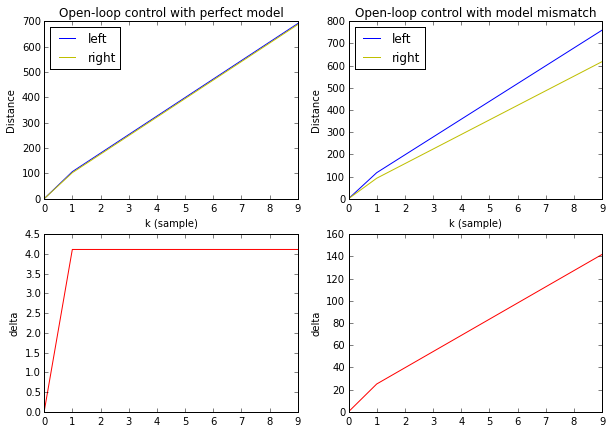

In [8]:
titles = ["Open-loop control with perfect model",
          "Open-loop control with model mismatch"]
_,_ = two_sims(driveStraight_left_OL, driveStraight_right_OL, titles)

From the above plots, we can see that the open-loop car travels straight only with a perfect model.

## Jolt Calculation
Before we implement the open loop controller that we just designed, let's implement an initial jolt for our motors. The idea behind this is that, as we learned in the System ID lab, our motors likely do not behave in the same way. In order to try to get uniform behavior (jolt the car straight), we want to calculate the PWM (input) values that give the maximum velocities attainable by both wheels.

This is implemented below by calculating the inputs that results in the minimum of the maximum velocities of both wheels. 

- **Make sure your `data_coarse.txt` file from System ID is in the same directory as the iPython notebook.**
- Run the code below to find your initial jolt values.
- Your initial jolt values are correct if they are the input values that correspond to the points where the blue and yellow lines intersect the green line respectively.

int left_jolt = 200;
int right_jolt = 240;


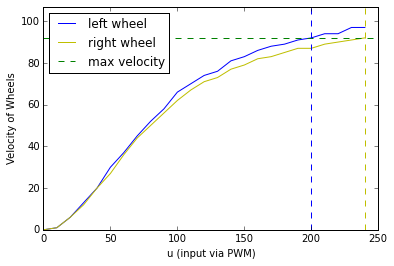

In [10]:
def find_closest_idx(arr, val):
    """
    Given an array of velocities and a value, returns the index of the array where arr[index] is the closest to the given value
    """
    return np.array(abs(arr-val)).argmin()

def find_jolt(): 
    with open('data_coarse.txt', 'r') as file:
        data = np.array([[int(num) for num in line.strip().split(',')] for line in file.readlines()])

    # compute velocity from distances
    dleft  = data[:, 1]
    dright = data[:, 2]
    vleft  = dleft[1:]  - dleft[:-1] 
    vright = dright[1:] - dright[:-1]
    u = data[1:, 0].reshape((-1, 1)) # duty cycle

    left_des, _ = np.array_split(vleft, 2)
    right_des, _ = np.array_split(vright, 2)
    u_des, _ = np.array_split(u, 2)
    
    plt.figure()
    plt.axis((0, 250, 0, max(max(left_des), max(right_des))+10))
    max_vel = min(max(left_des), max(right_des))
    plt.plot(u_des, left_des, 'b',  u_des, right_des, 'y')
    plt.axhline(max_vel, color='g', linestyle='--')
    plt.xlabel("u (input via PWM)")
    plt.ylabel("Velocity of Wheels")
    labels = ("left wheel" , "right wheel", "max velocity")
    plt.legend(labels, loc=2)
    
    left_idx = find_closest_idx(left_des, max_vel)
    right_idx = find_closest_idx(right_des, max_vel)
    left_jolt = u_des[left_idx][0]
    right_jolt = u_des[right_idx][0]
    plt.axvline(left_jolt, color='b', linestyle='--')
    plt.axvline(right_jolt, color='y', linestyle='--')
    return left_jolt, right_jolt

left_jolt, right_jolt = find_jolt()
print('int left_jolt = {};\nint right_jolt = {};'.format(left_jolt, right_jolt))

## Open Loop Implementation

Now implement the controller on the Launchpad. The sketch **`open_loop.ino`** contains some code that implements the open loop control.

- Fill in these values in `CODE BLOCK CON1`:
    - desired velocity: `v_star` 
    - estimated parameters: `theta_left`, `theta_right`, `beta_left`, `beta_right`
    - initial jolt values: `left_jolt`, `right_jolt`
    
    
- Additionally, we need to compute the PWM input to the motors in `CODE BLOCK CON2`:
    - Complete `driveStraght_left_OL()` and `driveStraight_right_OL()` to compute `left_cur_pwm` and `right_cur_pwm` (the PWM inputs for each wheel required for a desired v_star)
    
    
- Fill out `CODE BLOCK CON0` to calculate the control inputs using the functions from `CODE BLOCK CON2`.
- Upload the sketch to your Launchpad.
- **Make sure that the car is suspended above the desk.** Your car wheels are going to move in this step.

Once you are satisfied that your motors work and your open loop control is implemented, put the car on the ground. Switch the motors on and press the reset button. SIXT33N should move straighter than previously because you have accounted for differences in the two motors. Does it behave how you expect? It's okay if it doesn't drive completely straight at this stage.

<img width='15px' align='left' src="http://inst.eecs.berkeley.edu/~ee16b/sp16/lab_pics/check.png"> 

### <span style="color:green">CHECKPOINT 0.5:</span>
<span style="color:green">**Show your GSI the functioning open-loop control.**</span>


<a id='part2'></a>
## <span style="color:blue">Part 2: Closed Loop Simulation and Modeling</span>

## Closed Loop Design

Now that we have an open loop model, we can build a closed loop controller that uses feedback to ensure that both wheels drive at the same velocity. The controller has 2 inputs, namely the desired velocity and the difference between the wheel distances $\delta[k] = d_L[k] - d_R[k]$.

### 1. Read <a href="https://inst.eecs.berkeley.edu/~ee16b/fa17/proj/controls-primer.pdf">this PDF</a> for the derivation of the closed-loop system and its eigenvalue.



<span style='color:red'>** 2. Using the information above, draw a block diagram of both wheels' controllers.**</span> Show this diagram to your GSI before moving on. Keep this somewhere, as you will use it in your report.

<span style='color:red'>** 3. Now derive the closed loop update equation for the differences $\delta[k]$ corresponding to your controller.**</span> Keep this somewhere, as you will use it in your report.

Now that we've derived the model, we can begin implementing it. Fill in the two functions below.

In [33]:
# DESIGN YOUR CLOSED-LOOP CONTROL HERE
def driveStraight_left_CL(v_star, delta):
    # YOUR CODE HERE

    
    return (v_star+beta_left+delta)/theta_left 

def driveStraight_right_CL(v_star, delta):
    # YOUR CODE HERE
    
    return (v_star+beta_right+delta)/theta_right 

## Closed Loop Simulation and K-Value Selection

Next we need to choose values for the control gains so that the $\delta[k]$ update equation is stable. There should be a range of parameter values that make it stable, so we can tune the gains to get the desired performance.

The first plot below shows the car's performance given a model that exactly matches the physical car. In this case, $\delta$ converges to 0. The second plot shows that under model mismatch, $\delta$ actually converges to a nonzero value, $\delta_{ss}$. **Remember the car is still traveling straight in this scenario.** At this value, the turning effect of the terms $-k_L\delta_{ss}/\theta_R$ and $k_R\delta_{ss}/\theta_R$ in the closed-loop equations cancel out the turning effect of the model error.

<span style='color:red'>**Try the 5 different sets of gains below and see the effect of each.**</span>

Steady state error = 0.00
Steady state error = 14.46
kL=-0.1, kR=0.7
Eigenvalue of system: 1-kL-kR=0.4; stable


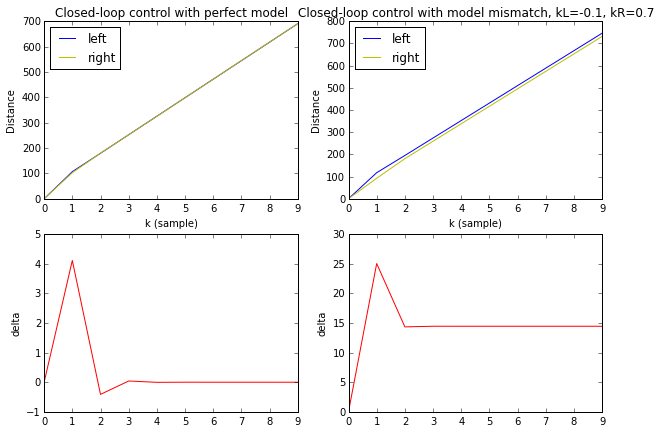

In [36]:
#k_left, k_right, stab = -0.3, 0.3, "marginally stable"
# k_left, k_right, stab = 0.5, 0.5, "stable, corrects error in one step"
# k_left, k_right, stab = 1, 1, "oscillatory, marginally stable"
# k_left, k_right, stab = 1.1, 1.1, "oscillatory, unstable"
# k_left, k_right, stab = 0.2, 0.2, "stable"
k_left, k_right = -.1, .7

titles = ["Closed-loop control with perfect model",
          "Closed-loop control with model mismatch, kL={}, kR={}".format(k_left, k_right)]
_, delta = two_sims(driveStraight_left_CL, driveStraight_right_CL, titles)

print("kL={}, kR={}".format(k_left, k_right))
print("Eigenvalue of system: 1-kL-kR={:.2g}; {}".format(1-k_left-k_right, stab))
steady_state_error = delta[-1]

## Closed Loop Implementation

Now implement the controller on the Launchpad. The sketch **`closed_loop.ino`** contains some code that implements the closed loop control. 

- Copy `CODE BLOCK CON1` from **`open_loop.ino`** and add your control gains **`k_left`** and **`k_right`**.
- Fill out `CODE BLOCK CON2` with your closed-loop control scheme.
- Fill out `CODE BLOCK CON0` in the body of the loop function to calculate the control inputs. Inspect this code to see how the control system is implemented. For now, ignore the term `delta_ss`, as it's currently set to 0.
- Upload the sketch to your LaunchPad.
    - Make sure that the car is suspended above the desk. Your car wheels are going to move in this step.
    - Check that the wheels are moving as you expect them to.
    - If you use your hand to put some friction on the wheels, does the feedback correct for it?

Once you are satisfied that your motors work and your closed-loop control is implemented, run the car on the ground. If it behaves erroneously (for example the controller oscillates), try different eigenvalues. Our simulations compare our possibly mismatched linear model with a linear approximation of our car. In reality, the car is a nonlinear system.

**Note:** It's possible that the car curves *slightly* over long distances, even if it the car thinks it's traveling straight. This can be due to factors such as mechanical differences past the shaft of the motor, including slight variation in wheel size or wheel wobble. We can fix this after we make the car turn.

<span style='color:red'>**What are some reasons why the simulation might behave differently from the car? What about the differences between when the car is on the ground versus when it is on the desk?**</span>

<img width='30px' align='left' src="http://inst.eecs.berkeley.edu/~ee16b/sp16/lab_pics/check.png">
<br/>
## <span style="color:green">CHECKPOINT 1</span>
<span style="color:green">**Show your GSI that you have implemented the closed loop control in closed_loop.ino.**</span>
## <span style="color:green">**You do NOT need to run closed_loop.ino and the car does NOT need to go straight at this stage.**</span>

<a id='part3'></a>
## <span style="color:blue">Part 3: Driving Straight</span>

## K-Value Tuning

How did the car behave? It probably didn't go perfectly straight with the first set of k values that you picked. In order to find the "right" k values, we will need to analyze the behavior of our car. Recall in lecture that we learned about how the control values will affect the convergence of a system.


<img width='600px' src="https://upload.wikimedia.org/wikipedia/commons/c/c0/Change_with_Ki.png">

The above plot can be summarized as:
- if k is too small, it takes a long time to converge to our desired solution
- if k is too big, oscillations happen

We can use this information to help guide us to k values that get our car going straight. Check out this youtube playlist if you need some examples of what each case could look like: https://www.youtube.com/playlist?list=PLQ1OVCqw6RUPgCmv8H6y9qbcMBT8lotDt

You will likely have to try several sets of k values until you find one that works well with your particular car. If you find yourself having a lot of trouble narrowing in on some, ask your GSI for help!

## Steady State Error Correction

Lastly, what if we want the car to travel in (approximately) the same direction as when it starts moving? We can manually add the known steady state error $\delta_{ss}$ to each calculation of the error $\delta$. Accounting for the known $\delta_{ss}$ helps the model better respond to unexpected pertubations affecting $\delta$ which increases the model's control strength.

We now calculate $\delta[k]=d_L - d_R + \delta_{ss}$.


Steady state error = unbounded


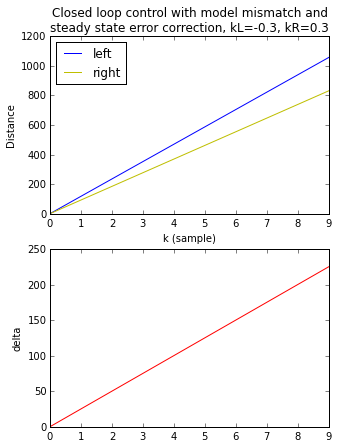

In [13]:
plt.figure(figsize=(5, 7))
plt.subplot(211)
# Simulate using steady_state_error
delta = sim(params, driveStraight_left_CL, driveStraight_right_CL, mismatch_error, steady_state_error)
plt.title("Closed loop control with model mismatch and\nsteady state error correction, kL={}, kR={}".format(k_left, k_right))
plt.subplot(212)
plt.plot(delta, 'r')
plt.ylabel('delta')

- `closed_loop.ino` collects data as it runs, including $\delta[k]$.
    - Let the car run until it settles to (approximately) straight.
    - Switch off the motors and plug the MSP into your computer.
    - Close the serial monitor (if it's open), and reopen the serial monitor.
- Note the steady-state value $\delta_{ss}$.
    - The first column of the printed data is $\delta$ over time.
    - **If $\delta$ doesn't reach steady-state, the car is not going straight according to the sensors.**
        - It's okay if it isn't exactly constant.
        - Just be sure the variation is small in proportion to the average value.

## Implementing Steady State Error Correction

- Input your value of $\delta_{ss}$ in `CODE BLOCK CON3` in **`closed_loop.ino`**.
- Convince yourself that we need to *add* this value in `CODE BLOCK CON0`.

For example, if the car drives straight but turned right from its initial heading, we want the right wheel to farther so it turns back towards the left. Adding a positive number to delta accomplishes this.

<img width='30px' align='left' src="http://inst.eecs.berkeley.edu/~ee16b/sp16/lab_pics/check.png">
<br/>
## <span style="color:green">CHECKOFF 2</span>
 <span style="color:green">**Show your GSI that your car moves in a straight line.** Your GSI will also check your block diagram and k values.</span>